# Primal-Dual algorithm for Total Variation processing on graphs.
- **TIP**: *It is recommended to understand the code in the Tikhonov_reg notebook before understanding this notebook*.
- We shall be doing  pointcloud shape{x,y,z} processing using Total Variation on Graphs.
- To create the graph, see *Graph_construction* notebook.
- We shall be using Chambolle-Pock algorithm(2010).
- Consider the following functional to be minimized:
    \begin{equation}\label{eq:optimization_problem}
    f^{*} = \underset{f}{\arg\min} \  \tfrac{1}{2}\|f-f_0\|^2 +  \lambda \|\nabla_\omega f\|_{1,p} \\
    \text{where} \ \ \|\nabla_\omega f\|_{1,p} = \sum_{i \in V}\|\nabla_\omega f_i\|_{p}\\
    \text{and}\quad p\in\{1,2\}
    \end{equation}
- For p = 1, this becomes anisotropic processing and for p = 2, this becomes isotropic processing.
- The above functional can be casted as the following saddle point problem :

$$ \min_{f}\max_{g}\langle Kf,g \rangle + B(f) - A^{*}(g)$$
- Here $g$ is the dual variable, $A \equiv \|.\|_{1,p}$, $B \equiv \tfrac{1}{2\lambda}\|. - f_0\|^{2}_{2}$ and $K\equiv \nabla_{\omega}$.
- For pointclouds $f \in \mathbb{R}^{|V|x3}$ and $g \in \mathbb{R}^{|V|x|V|x3}$. Here $|V|$ is the number of nodes in a graph *i.e.* the number of points in a pointcloud and 3 comes from 3 shape channels {x,y,z}.
- The following algorithm shall be implemented :
\begin{align*}
g^{(t+1)} &= \mathcal{P}_{\beta A^\ast }(g^{(t)}+\beta K \bar{f}^{(t)})\\
f^{(t+1)} &= \mathcal{P}_{\tau B}(f^{(t)}-\tau K^\ast g^{(t+1)})\\
\bar{f}^{(t+1)} &= f^{(t+1)}+ \theta(f^{(t+1)}-f^{(t)})
\end{align*}
- The proximal operator $\mathcal{P}_{\tau B}(f)$ is given as :
$$ \mathcal{P}_{\tau B}(f) = \tfrac{\lambda f + \tau f_0}{\lambda + \tau} $$
- The proximal operator $\mathcal{P}_{\beta A^{*}}(g)$ depends upon the value of $p$ in the norm. We shall find it, as we proceed in this notebook.
- The initialization shceme is $f^{(0)} = \bar{f}^{(0)} = f_0$ and $g^{(0)} = \nabla_\omega f_0$.
- Set $\tau, \beta >0$ such that $ \tau \beta \|{K}\|^2<1 $  and $\  \theta \in [0,1]$
- A common choice is to set $\tau = \beta = (4 \max_{i \in V}\sum_{j\in N(i)}\omega_{i,j})^{-1}$ and $\theta = 1$.


In [1]:
import torch
from tqdm import tqdm
from torch_scatter import scatter
from utilities import *
dev = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# load the graph
graph = torch.load("./data/3d_signal.pt")
graph = graph.to(dev)

In [4]:
#visualize the NOISY ponitcloud if required: #Open3d visualization works only locally!
displaySur(**dict(position=graph.x.cpu().numpy(), texture=graph.tex.cpu().numpy())) 

# Implement a base Primal-Dual class
We shall be implementing the $\mathcal{P}_{\tau B}(f)$ and iterative scheme, but we will leave the $\mathcal{P}_{\beta A^{*}}(g)$ for now.

In [5]:
class PD:
    """
    class to implement primal dual algo.
    """
    def __init__(self, graph, **kwargs):
        self.edge_index = graph.edge_index
        self.edge_attr = graph.edge_attr
        self.dim_size = kwargs["dim_size"] 
        self.f0 = kwargs["noisy_sig"]
        self.lamb = kwargs["lamb"]
        self.tau = kwargs["tau"]
        self.beta = kwargs["beta"]
        self.theta = kwargs["theta"]
        self.dev = kwargs["dev"]

    def grad(self, Xb):
        return torch.sqrt(self.edge_attr) * (Xb[self.edge_index[0]] - Xb[self.edge_index[1]]) 

    def proj(self,T):
        pass 
    
    def prox(self,U):
        return (self.lamb * U + self.tau * self.f0)/(self.lamb + self.tau)

    def grad_conj(self, P): # grad_conj = -divergence
        out1 = scatter(torch.sqrt(self.edge_attr) * P, self.edge_index[1], dim=0, dim_size=self.dim_size, reduce="add")
        out2= scatter(torch.sqrt(self.edge_attr) * P, self.edge_index[0], dim=0, dim_size=self.dim_size, reduce="add")
        return  (out2 - out1) 
    
    def run(self,itr, X):
        Xb = X
        P = self.grad(X)
        for i in tqdm(range(itr)):
            P = self.proj(P + self.beta* self.grad(Xb))
            tmp_X = X.clone()
            X = self.prox(X - self.tau * self.grad_conj(P)) 
            Xb = X + self.theta*(X-tmp_X)
        return X

# Case-1, anisotropic p = 1
The proximal operator $\mathcal{P}_{\beta A^{*}}(g)$ in this case is given as:
$$ \mathcal{P}_{\beta A^{*}}(g)_{i,j,k} = \mathcal{Proj}_{\mathcal{B}_{\infty,\infty}}(g)_{i,j,k} = \frac{g_{i,j,k}}{\max\{1,|g_{i,j,k}|\}}$$
Recall that $g \in \mathbb{R}^{|V|x|V|x3}$ 

In [6]:
class PD_TV1(PD):
    def proj(self,T):
        return (T/torch.clamp(torch.abs(T),1))    

In [7]:
lamb = 0.005
itr = 5000
theta = 1
# Calculates the \max_{i \in V}\sum_{j\in N(i)}\omega_{i,j}
k_prime = torch.max(scatter(graph.edge_attr, graph.edge_index[1],dim=0, dim_size=graph.x.shape[0], reduce="add")).item()
beta = 1/(2*k_prime)
tau = 1/(8*k_prime)
pd_tv1 = PD_TV1(graph, **dict(dim_size = graph.x.shape[0], noisy_sig=graph.x, tau=tau, lamb=lamb, beta = beta, theta=theta, dev=dev))
new_sig_tv1 = pd_tv1.run(itr,graph.x)

100%|██████████| 5000/5000 [00:01<00:00, 2860.66it/s]


In [8]:
displaySur(**dict(position=new_sig_tv1.cpu().numpy(), texture=graph.tex.cpu().detach())) # displays the processed pointcld.


# Case-2, isotropic p=2
The proximal operator $\mathcal{P}_{\beta A^{*}}(g)$ in this case is given as:
$$ \mathcal{P}_{\beta A^{*}}(g)_{i,j,k} = \mathcal{Proj}_{\mathcal{B}_{\infty,2}}(g)_{i,j,k} = \frac{g_{i,j,k}}{\max\{1,\|g_{i,.}\|_{2}\}}$$
Recall that $g \in \mathbb{R}^{|V|x|V|x3}$, here $\|g_{i,.}\|_{2}$ is the $L_2$ norm corresonding to $i^{th}$ row tensor of size $|V|x3$

In [9]:
class PD_TV2(PD):
    def proj(self,T):
        aggr_out = scatter(torch.pow(T,2), self.edge_index[1], dim=0, dim_size=self.dim_size, reduce="add")
        a = torch.sqrt(aggr_out)
        b = torch.norm(a,dim=1)
        b = b.view(-1,1)
        return (T/torch.clamp(b[self.edge_index[1]],1)) 

In [10]:
lamb = 0.05
itr = 5000
theta = 1
# Calculates the \max_{i \in V}\sum_{j\in N(i)}\omega_{i,j}
k_prime = torch.max(scatter(graph.edge_attr, graph.edge_index[1],dim=0, dim_size=graph.x.shape[0], reduce="add")).item()
beta = 1/(2*k_prime)
tau = 1/(8*k_prime)
pd_tv2 = PD_TV2(graph, **dict(dim_size = graph.x.shape[0], noisy_sig=graph.x, tau=tau, lamb=lamb, beta = beta, theta=theta, dev=dev))
new_sig_tv2 = pd_tv2.run(itr,graph.x)

100%|██████████| 5000/5000 [00:02<00:00, 2065.11it/s]


In [11]:
displaySur(**dict(position=new_sig_tv2.cpu().cpu().numpy(), texture=graph.tex.cpu().numpy())) # displays the processed pointcld.


# Use a non-squared Data-Fidelity term:
- The following minization is known to preserve the contrast/volume for color/shape processing:
\begin{equation}
 f^{*} = \underset{f}{\arg\min} \ \|f-f_0\|_{1} +  \lambda \|\nabla_\omega f\|_{1,p} \\
\end{equation}
- The inspiration comes from the 2010 paper of chambolle-pock
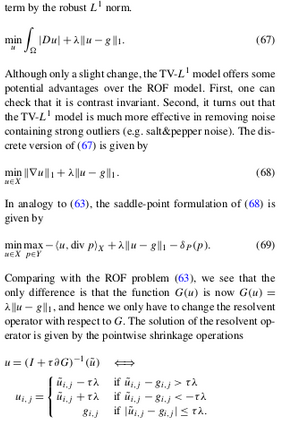
- However, we are interested in minimizing the non-squared $L2$ norm in Data-Fidelity term:

\begin{equation}
 f^{*} = \underset{f}{\arg\min} \ \|f-f_0\|_{2} +  \lambda \|\nabla_\omega f\|_{1,p = 1} \\
\end{equation}

- With a little bit of effort it can be shown that the proximal operator $\mathcal{P}_{\tau B}(f)$, where $B \equiv \tfrac{1}{\lambda}\|. - f_0\|_{2}$ is given as:
$$f_{0,i} + \left( 1 - \frac{\frac{\tau}{\lambda}}{\max({\frac{\tau}{\lambda}, \|f_i - f_{0,i}\|_{2}})}  \right)(f_i - f_{0,i})$$


In [13]:
class PD_L2DF(PD):
    def prox(self,U):
        return self.f0 + (1 - ((self.tau/self.lamb)/ torch.where( torch.norm(U-self.f0, dim=1).view(-1,1) >= torch.tensor(self.tau/self.lamb).type(torch.float32).to(self.dev), torch.norm(U-self.f0, dim=1).view(-1,1) , torch.tensor(self.tau/self.lamb).type(torch.float32).to(self.dev)))) * (U-self.f0)
    def proj(self,T):
        return (T/torch.clamp(torch.abs(T),1)) 

In [14]:
lamb = 0.15
itr = 5000
theta = 1
# Calculates the \max_{i \in V}\sum_{j\in N(i)}\omega_{i,j}
k_prime = torch.max(scatter(graph.edge_attr, graph.edge_index[1],dim=0, dim_size=graph.x.shape[0], reduce="add")).item()
beta = 1/(2*k_prime)
tau = 1/(8*k_prime)
pd_l2df = PD_L2DF(graph, **dict(dim_size = graph.x.shape[0], noisy_sig=graph.x, tau=tau, lamb=lamb, beta = beta, theta=theta, dev=dev))
new_sig_l2df = pd_l2df.run(itr,graph.x)

100%|██████████| 5000/5000 [00:02<00:00, 1675.64it/s]


In [15]:
displaySur(**dict(position=new_sig_l2df.cpu().numpy(), texture=graph.tex.cpu().numpy())) # displays the processed pointcld.


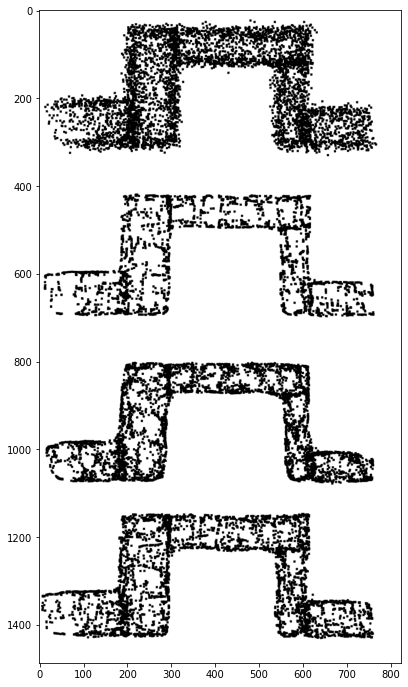

In [16]:
# You should see something like this, in the following order:
#Original poincloud
#Case-1 (aniso TV)
#Case-2 (iso TV)
#Non-squared L2 DF term
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
res = mpimg.imread("./data/out_shape.png")
f = plt.figure(figsize=(12,12))
plt.imshow(res, cmap="gray")
plt.show()

# Exercise

- Modify the `def prox()` method to solve for the non-squared L1 data-fidelity term in the following functional:
\begin{equation}
 f^{*} = \underset{f}{\arg\min} \ \|f-f_0\|_{1} +  \lambda \|\nabla_\omega f\|_{1,p = 1} \\
\end{equation}
